# Analyzing GDC Data Using GA4GH DOS

In this demonstration we will use a [dos-gdc-lambda](https://github.com/david4096/dos-gdc-lambda/) to access data using GA4GH compliant methods. There is a wealth of public data available for analysis let's see what we get!

## Getting a listing of data

Using the GA4GH client we can quickly get a listing of available data objects.

In [1]:
from ga4gh.dos.client import Client
local_client = Client('https://gmyakqsfp8.execute-api.us-west-2.amazonaws.com/api/')
client = local_client.client
models = local_client.models
ListDataObjectsRequest = models.get_model('ga4ghListDataObjectsRequest')
list_request = client.ListDataObjects(body=ListDataObjectsRequest(page_size=100))
list_response = list_request.result()
print("Number of Data Objects: {} ".format(len(list_response.data_objects)))

Number of Data Objects: 100 


### Iterating to get a larger portion of the index

Data from GDC are returned following the GA4GH page_size. However, we would like to retrieve more and so pmap function to grab many pages in parallel.

In [2]:
data_objects = []
page_token = None

from pmap import pmap

def list_data_objects(page):
    list_request = client.ListDataObjects(body=ListDataObjectsRequest(page_size=100, page_token=100*page))
    list_response = list_request.result()
    page_token = list_response.next_page_token
    return list_response.data_objects

%time data_objects = list(pmap(list_data_objects, range(1000), threads=16))

CPU times: user 59.4 s, sys: 12.8 s, total: 1min 12s
Wall time: 1min 14s


In [3]:
data_objects = reduce(lambda x, y: x + y, data_objects)
len(data_objects)

100000

## Visualizing summary data

These data, indexed by the GDC API, are being made available to the GA4GH client using a lambda function which dynamically creates an interoperability layer.

Let's start by looking at a histogram of the file sizes represented in the portion of the GDC data requested. We'll set the y-axis to log since there are a lot of very small files and a few very large ones.

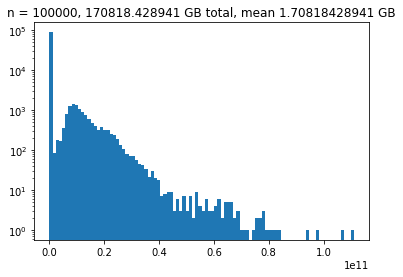

In [4]:
import matplotlib.pyplot as plt
file_sizes = [float(x.size) for x in data_objects]
plt.hist(file_sizes, bins=96)
plt.title("n = {}, {} GB total, mean {} GB".format(len(file_sizes), str(sum(file_sizes) / 1000000000.0), (sum(file_sizes) / len(file_sizes)) / 1000000000.0 ))
plt.yscale('log')
plt.show()

## Filtering for public data

Currently, we rely on metadata from GDC to reason about the access controls on data. We'll also look at the overall picture of these file sizes.

In [5]:
public_data_objects = filter(
    lambda x: x['urls'][0]['system_metadata']['access'] == 'open', 
    data_objects)
print('Number of public Data Objects: {}'.format(len(public_data_objects)))

Number of public Data Objects: 49885


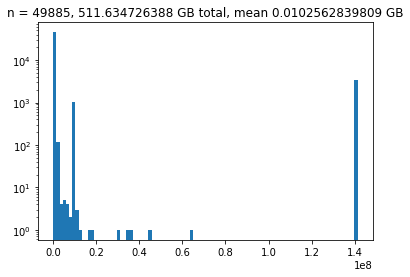

In [6]:
file_sizes = [float(x.size) for x in public_data_objects]
plt.hist(file_sizes, bins=96)
plt.title("n = {}, {} GB total, mean {} GB".format(len(file_sizes), str(sum(file_sizes) / 1000000000.0), (sum(file_sizes) / len(file_sizes)) / 1000000000.0 ))
plt.yscale('log')
plt.show()

Note that we can see immediately that most of the public data are small files, under 100MB.

## Analyzing data from DOS

Counts from data are considerable non-identifiable and public. They let us understand the variety of tumors that exist in this case.

In [7]:
public_htseq_counts = fi%matplotlib notebook
lter(
    lambda x: x.name.endswith('.htseq.counts.gz'), 
    public_data_objects)

In [9]:
len(public_htseq_counts)

4151

In [10]:
[x.name for x in public_htseq_counts][0:10]

[u'f5703c0c-00cc-481d-9296-416238a6f42b.htseq.counts.gz',
 u'47f0749e-01c7-4d8c-8926-06293c4a9b4e.htseq.counts.gz',
 u'a52e728c-c352-4fd7-8f3c-fe0fbf2854d0.htseq.counts.gz',
 u'e624e391-cfec-48d4-8d3d-4e84666b78b1.htseq.counts.gz',
 u'63691c59-d630-4b06-82bb-3d0587638a33.htseq.counts.gz',
 u'e4a20e3d-51ce-41a1-b200-0dcbfd01e674.htseq.counts.gz',
 u'fe9525e1-e83e-40ce-a2e2-91a8a6d0c982.htseq.counts.gz',
 u'a51b7073-656b-4fe2-a437-f3d573bab3ac.htseq.counts.gz',
 u'50e551a4-06dc-4bf4-a979-2552f1103f38.htseq.counts.gz',
 u'12a2d93e-8567-4a55-a3f3-4c94c51ffb6a.htseq.counts.gz']

We can now download these files in order to analyze them locally using a few simple functions.

In [15]:
import gzip
def unzip_file(zipped, unzipped):
    with open(unzipped, 'wb') as f:
        with gzip.open(zipped, 'rb') as z:
            f.write(z.read())

import requests
def download_file(url, filename):
    # NOTE the stream=True parameter
    r = requests.get(url, stream=True)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                #f.flush() commented by recommendation from J.F.Sebastian
    return filename

def download_unzip(do):
    download_file(do.urls[0].url, do.name)
    unzip_file(do.name, do.name.replace('.gz', ''))



In [16]:
download_unzip(public_htseq_counts[0])

We can then load this file and parse it using available means.

## Loading data directly into pandas

`pandas` proves useful when handling tabular data and we can use it here to gather compressed data directly into a dataframe in memory. This reduces the need for disk space.

In [11]:
import pandas as pd

In [12]:
df = pd.read_csv(
    public_htseq_counts[1].urls[0].url,
    sep='\t',
    compression='gzip',
    names=['feature', 'count'])

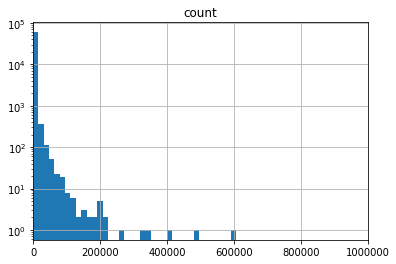

In [13]:
df.hist(bins=1000)
plt.yscale('log')
plt.xlim(0, 1000000)
plt.show()

## Performing a meta-analysis

Now that we are able to gather reasonable looking counts, we can perform a meta-analysis. Here we will look at the information content of each sample.

In [14]:
from skimage.measure import shannon_entropy as se
import numpy as np

In [15]:
se(np.array([x.count for x in list(df.itertuples())]))

10.182273880898508

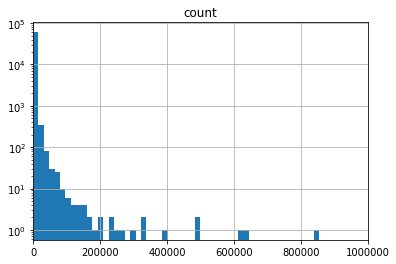

9.90091269254


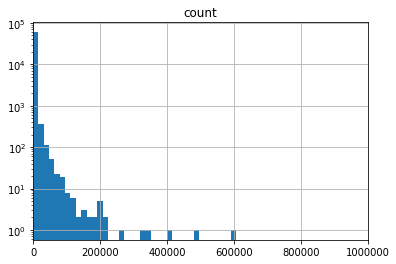

10.1822738809


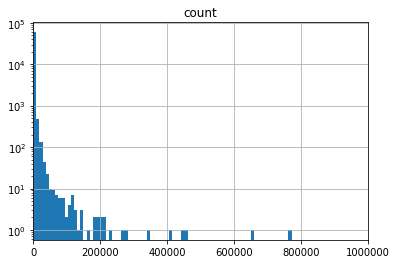

10.1605496981


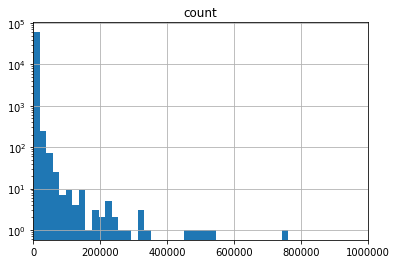

9.68154124978


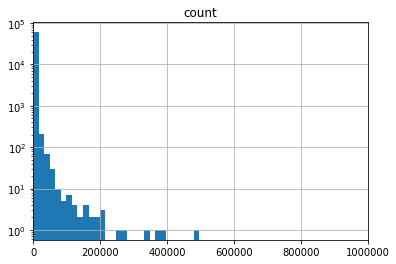

9.4551913051


In [16]:
entropies = []
for sample in public_htseq_counts[:5]:
    sampledf = pd.read_csv(
        sample.urls[0].url,
        sep='\t',
        compression='gzip',
        names=['feature', 'count'])
    sampledf.hist(bins=1000)
    plt.yscale('log')
    plt.xlim(0, 1000000)
    plt.show()
    entropy = se(np.array([x.count for x in list(sampledf.itertuples())]))
    print(entropy)
    entropies.append(entropy)

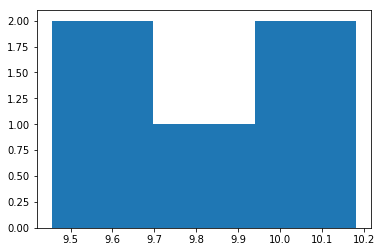

In [17]:
plt.hist(entropies, bins=3)
plt.show()

In [18]:
matrix = []
count = 0

def load_samples(sample):
    sampledf = pd.read_csv(
        sample.urls[0].url,
        sep='\t',
        compression='gzip',
        names=['feature', 'count'])
    return [x.count for x in list(sampledf.itertuples())]

%time matrix = list(pmap(load_samples, public_htseq_counts, threads=32))


CPU times: user 25min 29s, sys: 1min 8s, total: 26min 38s
Wall time: 24min 29s


In [19]:
len(matrix)

4151

In [20]:
from sklearn.decomposition import PCA
pca_values = PCA(n_components=5).fit_transform(matrix)

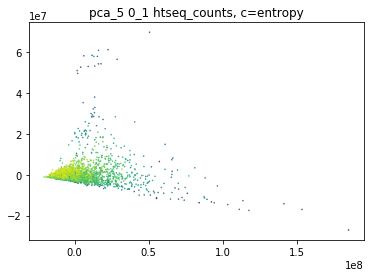

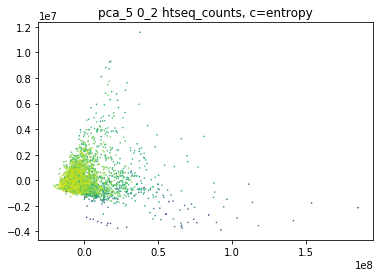

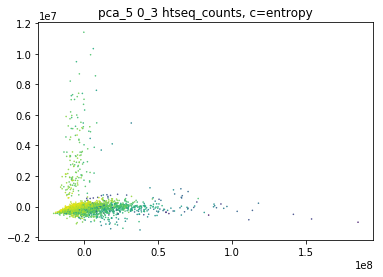

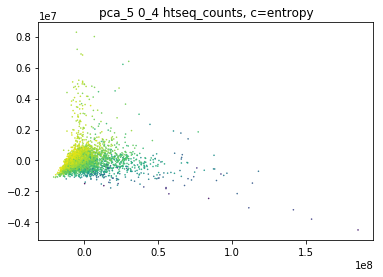

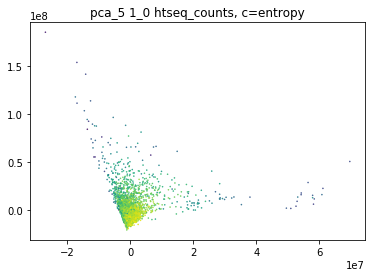

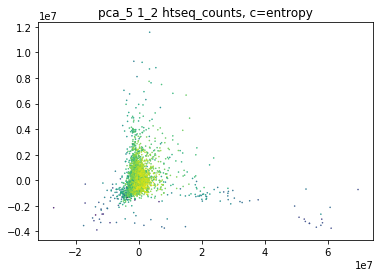

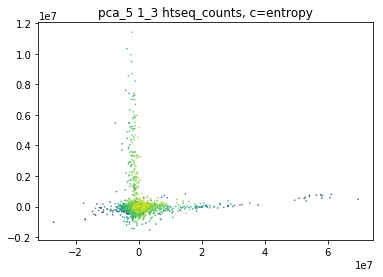

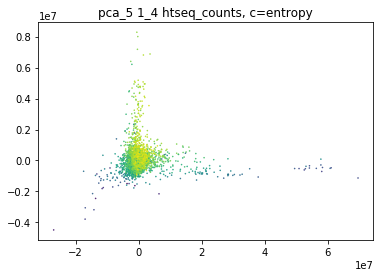

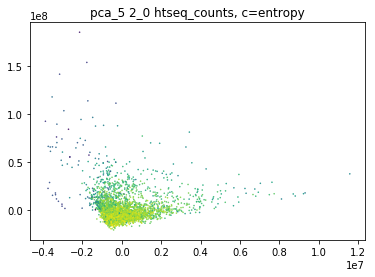

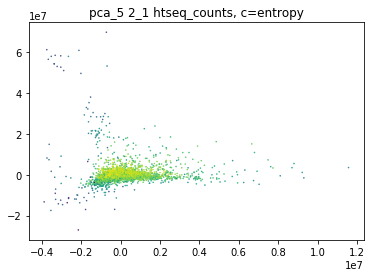

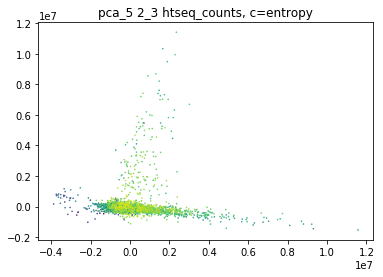

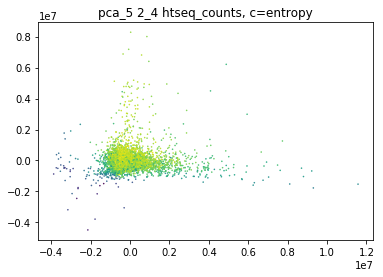

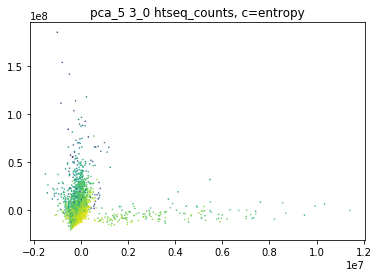

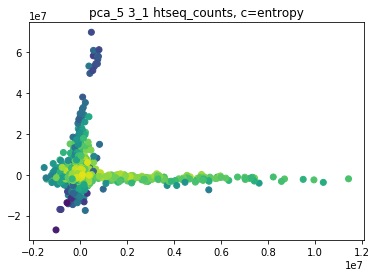

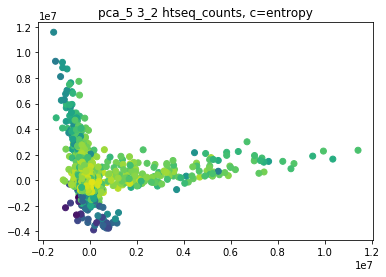

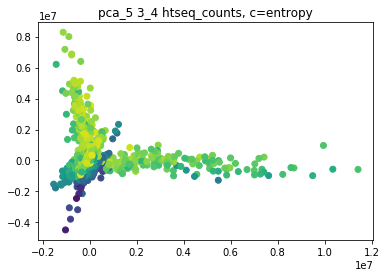

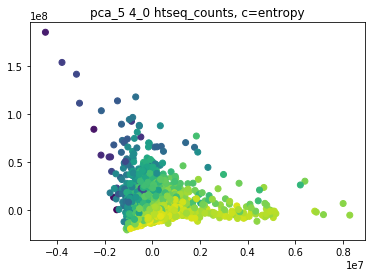

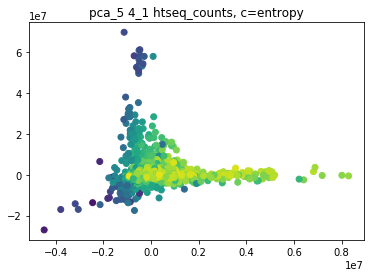

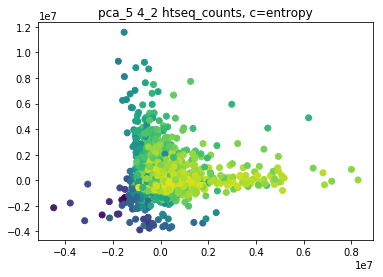

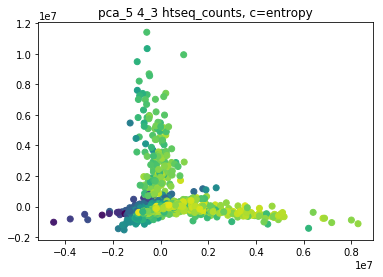

In [21]:
plt.title('pca_5 0_1 htseq_counts, c=entropy')
plt.scatter([x[0] for x in pca_values], [x[1] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 0_2 htseq_counts, c=entropy')

plt.scatter([x[0] for x in pca_values], [x[2] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 0_3 htseq_counts, c=entropy')

plt.scatter([x[0] for x in pca_values], [x[3] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 0_4 htseq_counts, c=entropy')

plt.scatter([x[0] for x in pca_values], [x[4] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 1_0 htseq_counts, c=entropy')

plt.scatter([x[1] for x in pca_values], [x[0] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 1_2 htseq_counts, c=entropy')

plt.scatter([x[1] for x in pca_values], [x[2] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 1_3 htseq_counts, c=entropy')

plt.scatter([x[1] for x in pca_values], [x[3] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 1_4 htseq_counts, c=entropy')

plt.scatter([x[1] for x in pca_values], [x[4] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 2_0 htseq_counts, c=entropy')

plt.scatter([x[2] for x in pca_values], [x[0] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 2_1 htseq_counts, c=entropy')

plt.scatter([x[2] for x in pca_values], [x[1] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 2_3 htseq_counts, c=entropy')

plt.scatter([x[2] for x in pca_values], [x[3] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 2_4 htseq_counts, c=entropy')

plt.scatter([x[2] for x in pca_values], [x[4] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 3_0 htseq_counts, c=entropy')

plt.scatter([x[3] for x in pca_values], [x[0] for x in pca_values], s=0.3, c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 3_1 htseq_counts, c=entropy')

plt.scatter([x[3] for x in pca_values], [x[1] for x in pca_values], c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 3_2 htseq_counts, c=entropy')

plt.scatter([x[3] for x in pca_values], [x[2] for x in pca_values], c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 3_4 htseq_counts, c=entropy')

plt.scatter([x[3] for x in pca_values], [x[4] for x in pca_values], c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 4_0 htseq_counts, c=entropy')

plt.scatter([x[4] for x in pca_values], [x[0] for x in pca_values], c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 4_1 htseq_counts, c=entropy')

plt.scatter([x[4] for x in pca_values], [x[1] for x in pca_values], c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 4_2 htseq_counts, c=entropy')

plt.scatter([x[4] for x in pca_values], [x[2] for x in pca_values], c=[se(np.array(x)) for x in matrix])
plt.show()
plt.title('pca_5 4_3 htseq_counts, c=entropy')

plt.scatter([x[4] for x in pca_values], [x[3] for x in pca_values], c=[se(np.array(x)) for x in matrix])
plt.show()

In [22]:
from sklearn.manifold import TSNE
%time tsne_values = TSNE(n_components=2, n_iter=500).fit_transform(matrix)


CPU times: user 18min 44s, sys: 22.9 s, total: 19min 7s
Wall time: 17min 53s


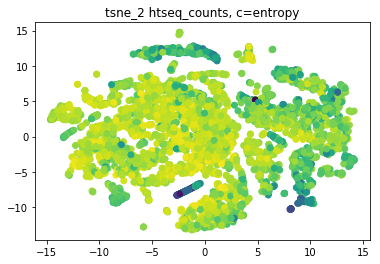

In [23]:
plt.title('tsne_2 htseq_counts, c=entropy')
plt.scatter([x[0] for x in tsne_values], [x[1] for x in tsne_values], c=[se(np.array(x)) for x in matrix])
plt.show()

In [24]:
from sklearn.cluster import AgglomerativeClustering

In [25]:
%time clusters = AgglomerativeClustering(n_clusters=12).fit_predict(pca_values)

CPU times: user 488 ms, sys: 32 ms, total: 520 ms
Wall time: 533 ms


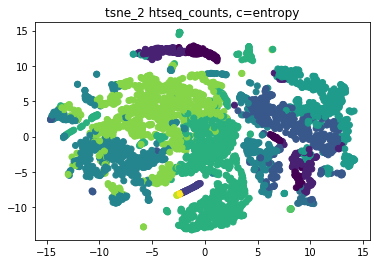

In [26]:
plt.title('tsne_2 htseq_counts, c=entropy')
plt.scatter([x[0] for x in tsne_values], [x[1] for x in tsne_values], c=clusters)
plt.show()

## Entropies by cluster

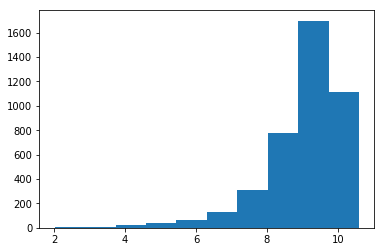

In [27]:
plt.hist([se(np.array(x)) for x in matrix])
plt.show()

In [28]:
with_clusters = zip(clusters, matrix)

In [29]:
entropies = []
clusters_list = []
for i in range(12):
    cluster = np.array([x[1] for x in filter(lambda x: x[0] == i, with_clusters)])
    clusters_list.append(cluster)
    entropies.append(se(cluster))


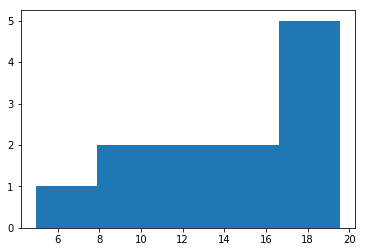

In [30]:
plt.hist(entropies, bins=5)
plt.show()

In [31]:
from sklearn.metrics import pairwise_distances

In [32]:
%time distances = pairwise_distances(matrix[0:1500])

CPU times: user 31.1 s, sys: 4.54 s, total: 35.7 s
Wall time: 19.3 s


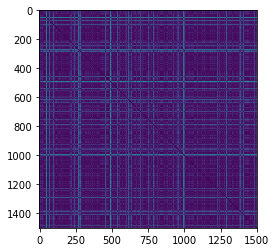

In [33]:
plt.imshow(distances)
plt.show()

In [34]:
%time distances = pairwise_distances(clusters_list[0])


CPU times: user 172 ms, sys: 112 ms, total: 284 ms
Wall time: 140 ms


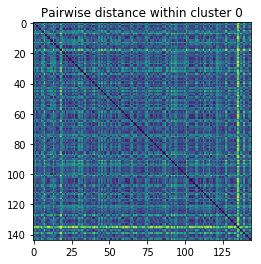

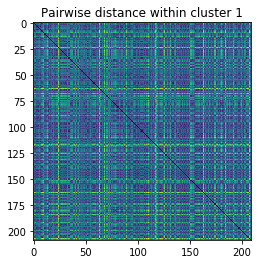

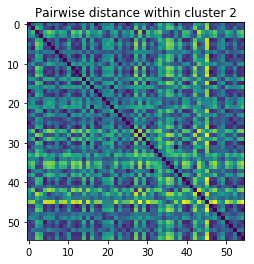

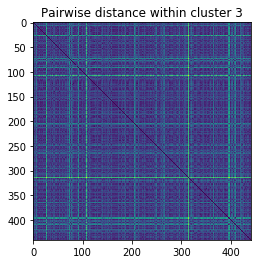

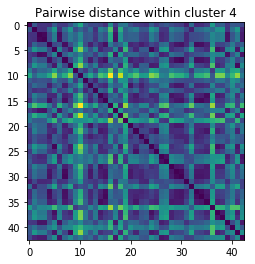

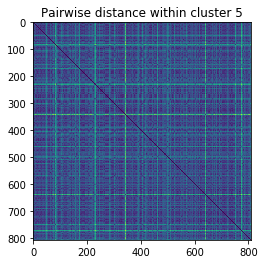

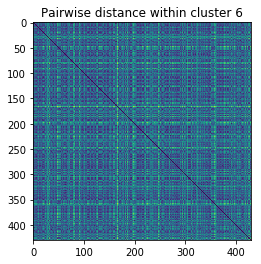

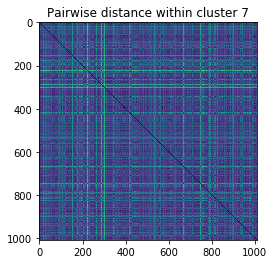

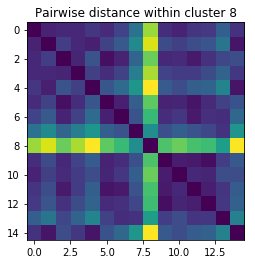

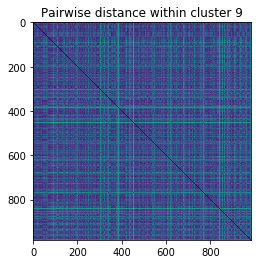

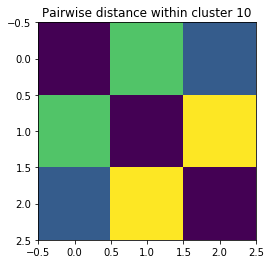

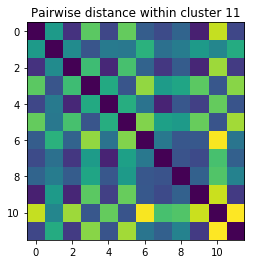

In [35]:
for i, cluster in enumerate(clusters_list):
    plt.title('Pairwise distance within cluster {}'.format(i))
    plt.imshow(pairwise_distances(cluster))
    plt.show()

In [36]:
cluster_ordered = [x for x in clusters_list[0]] + \
    [x for x in clusters_list[1]] + \
    [x for x in clusters_list[2]] + \
    [x for x in clusters_list[3]] + \
    [x for x in clusters_list[4]] + \
    [x for x in clusters_list[5]] + \
    [x for x in clusters_list[6]] + \
    [x for x in clusters_list[7]] + \
    [x for x in clusters_list[8]] + \
    [x for x in clusters_list[9]] + \
    [x for x in clusters_list[10]] + \
    [x for x in clusters_list[11]]

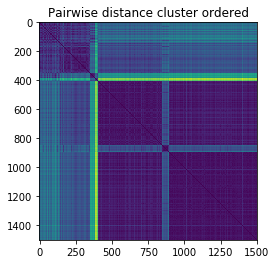

In [37]:
plt.title('Pairwise distance cluster ordered')
plt.imshow(pairwise_distances(cluster_ordered[0:1500]))
plt.show()

In [38]:
means = [np.mean(x) for x in matrix]

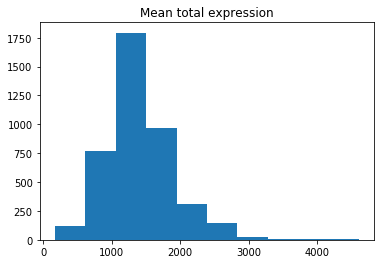

In [39]:
plt.title('Mean total expression')
plt.hist(means)
plt.show()

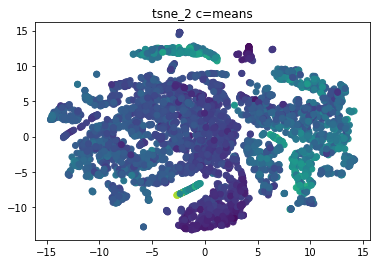

In [40]:
plt.title('tsne_2 c=means')
plt.scatter([x[0] for x in tsne_values], [x[1] for x in tsne_values], c=means)
plt.show()

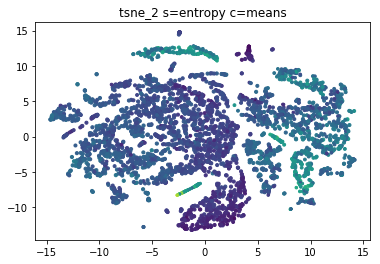

In [41]:
plt.title('tsne_2 s=entropy c=means')
plt.scatter([x[0] for x in tsne_values], [x[1] for x in tsne_values], s=[se(np.array(x)) for x in matrix], c=means)
plt.show()

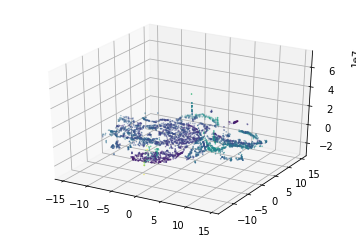

In [42]:
#%matplotlib notebook


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([x[0] for x in tsne_values], [x[1] for x in tsne_values], [x[1] for x in pca_values], c=means, marker='o', s=0.3)
plt.show()

In [43]:
%time tsne3_values = TSNE(n_components=3, n_iter=500).fit_transform(matrix)


CPU times: user 19min 10s, sys: 19.2 s, total: 19min 29s
Wall time: 18min 15s


<IPython.core.display.Javascript object>


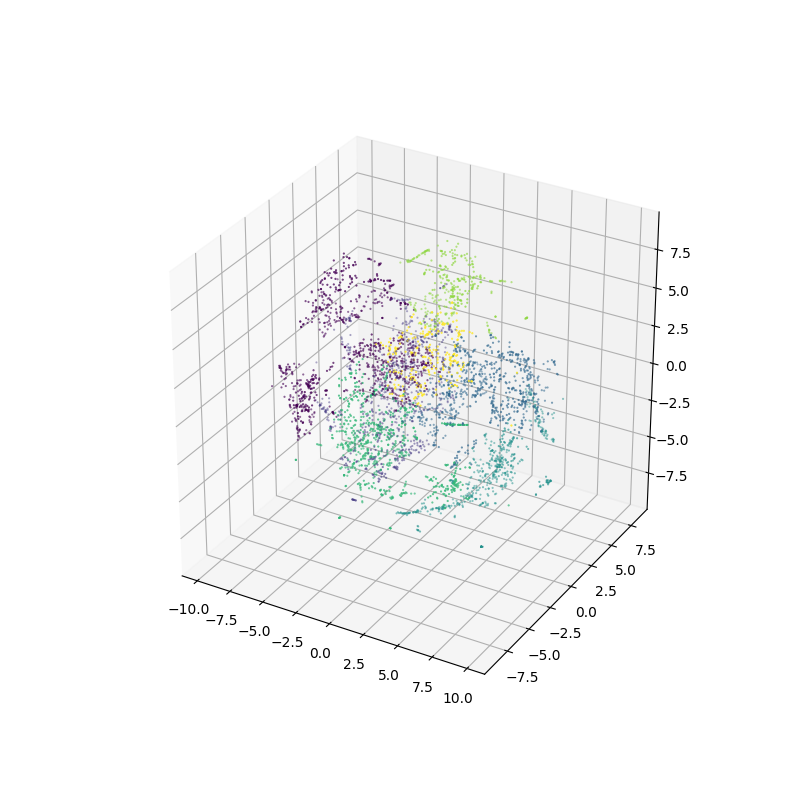

CPU times: user 512 ms, sys: 232 ms, total: 744 ms
Wall time: 574 ms


In [67]:
%matplotlib notebook

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
%time clusters = AgglomerativeClustering(n_clusters=7).fit_predict(tsne3_values)
with_clusters = 
ax.scatter([x[0] for x in tsne3_values], [x[1] for x in tsne3_values], [x[2] for x in tsne3_values], c=clusters, marker='o', s=0.3)
plt.show()

<IPython.core.display.Javascript object>


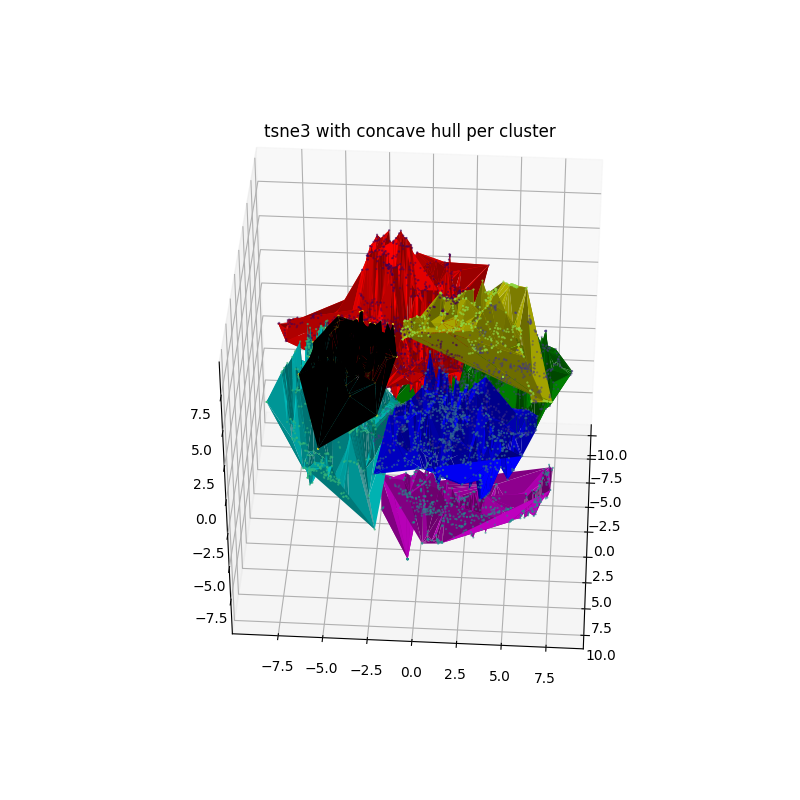

In [145]:
from scipy.spatial import ConvexHull
clusters_list = []
with_clusters = zip(clusters, tsne3_values)
for i in range(7):
    cluster = np.array([x[1] for x in filter(lambda x: x[0] == i, with_clusters)])
    clusters_list.append(cluster)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r', 'g', 'b', 'm', 'c', 'y', 'k']
ax.scatter([x[0] for x in tsne3_values], [x[1] for x in tsne3_values], [x[2] for x in tsne3_values], c=clusters, marker='o', s=0.3)
for i in range(7):
    ax.plot_trisurf([x[0] for x in clusters_list[i]], [x[1] for x in clusters_list[i]], [x[2] for x in clusters_list[i]], color=colors[i])
plt.title('tsne3 with concave hull per cluster')
plt.show()

In [45]:
%time tsne4_values = TSNE(n_components=4, n_iter=500).fit_transform(matrix)
# sort by a dimension
%time sortedtsne4 = tsne4_values[tsne4_values[:,0].argsort()]

CPU times: user 18min 35s, sys: 15.9 s, total: 18min 51s
Wall time: 17min 40s
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 969 µs


In [46]:
window = 10
for i in range(0, len(sortedtsne4), window):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter([x[0] for x in tsne4_values[0:i + window]], [x[1] for x in tsne4_values[0:i + window]], [x[2] for x in tsne4_values[0:i + window]], marker='o', s=0.6)
    plt.savefig('{}.png'.format(i))


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


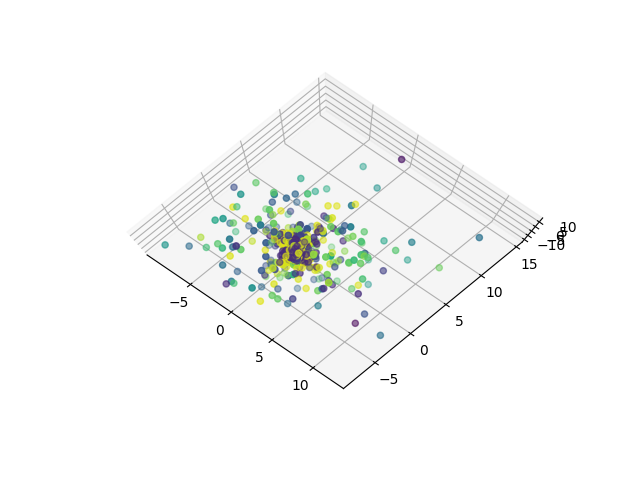

<IPython.core.display.Javascript object>


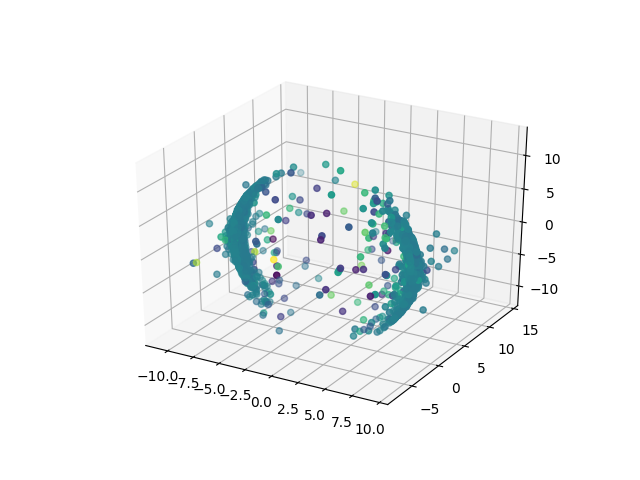

<IPython.core.display.Javascript object>


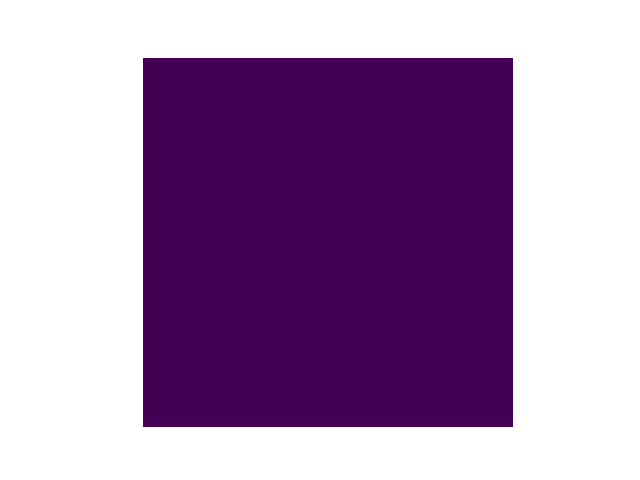

In [152]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([x[0] for x in tsne4_values], [x[1] for x in tsne4_values], [x[2] for x in tsne4_values], marker='o', c=[x[3] for x in tsne4_values])
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([x[3] for x in tsne4_values], [x[1] for x in tsne4_values], [x[2] for x in tsne4_values], marker='o', c=[x[0] for x in tsne4_values])

plt.show()
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter([x[0] for x in tsne4_values], [x[2] for x in tsne4_values], [x[3] for x in tsne4_values], marker='o', c=[x[1] for x in tsne4_values])

plt.show()